In [11]:
import os
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import pi, cos, exp, sqrt, log, sin
from numpy import array
from numpy import exp as exp_array
from numpy import cos as cos_array
import matplotlib.pyplot as plt
import collections
import functools
import pickle
from copy import deepcopy
%matplotlib inline 

In [76]:
def load_rdf(rdf_file):
    rdf_directory = "data/"
    rdf_data = pd.read_csv(filepath_or_buffer = rdf_directory + rdf_file, header = None, names = ["r", "g(r)", "status"], sep = " ")
    rdf_data = rdf_data[["r", "g(r)"]]
    return rdf_data
    
def asymptotic_rdf(r, a, z, k0, q):
    return r*r*a*(exp(-r/z)/r)*cos(k0*r + q)

def asymptotic_rdf_array(r, a, z, k0, q):
    return r*r*a*(exp_array(-r/z)/r)*cos_array(k0*r + q)

def make_r2hr(rdf_data):
    rdf_data["r2h(r)"] = rdf_data["g(r)"].apply(lambda x: x - 1.0)
    rdf_data["r2h(r)"] = rdf_data["r2h(r)"] * rdf_data["r"] * rdf_data["r"] 

def create_rdf_fit_data(rdf_data, r_low, r_hi):
    index = 0
    index_low = -1
    index_high = -1
    for r in rdf_data["r"]:
        if (r >= r_low) and (index_low == -1):
            index_low = index
        if (r >= r_hi) and (index_high == -1):
            index_high = index
        index = index + 1
    rdf_fit_data = rdf_data[index_low:(index_high+1)]
    return rdf_fit_data

def make_asymptotic_r2hr(popt, rdf_data):
    a = popt[0]
    z = popt[1]
    k0 = popt[2]
    q = popt[3]
    make_asymptotic_rdf = lambda x: asymptotic_rdf(x, a, z, k0, q)
    rdf_data["r2h(r)_asmpt"] = rdf_data["r"].apply(make_asymptotic_rdf)
    

def plot_fit(rdf_data, rdf_data_extended, x_min, x_max, y_min, y_max):
    #font scpecifications
    title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
    axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}
    axescolor = '#f6f6f6'

    #figure size and tick style
    plt.rcParams["figure.figsize"] = [6,6]
    plt.rc('axes',edgecolor='black',linewidth=1)
    plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    #actual data and labeling
    plt.xlabel('$\mathbf{r}$', fontsize=20, fontdict = axis_label_font)
    plt.ylabel('$\mathbf{r^{2}h(r)}$', fontsize=20, fontdict = axis_label_font)
    plt.plot(rdf_data["r"], rdf_data["r2h(r)"], c="r", linestyle = '-', linewidth = 7, alpha = 0.5)
    plt.plot(rdf_data_extended["r"], rdf_data_extended["r2h(r)_asmpt"], c="b", linestyle = '-', linewidth = 7, alpha = 0.3)
    plt.plot(rdf_data_extended["r"], rdf_data_extended["r2h(r)"], c="k", linestyle = '-', linewidth = 2)
    plt.ylim((y_min,y_max))
    plt.xlim((x_min,x_max))
    plt.xscale('log')

    #title and axis labels
    plt.tick_params(axis='both', labelsize=20)
    plt.title("Asymptotic fit", y=1.05, fontdict = title_font)
    
def extend_rdf(popt, rdf_data, r_max):
    a = popt[0]
    z = popt[1]
    k0 = popt[2]
    q = popt[3]
    simulation_data = deepcopy(rdf_data)
    simulation_data = rdf_data[["r", "r2h(r)", "r2h(r)_asmpt"]]
    dr = simulation_data["r"][1] - simulation_data["r"][0]
    r_start = simulation_data["r"].values[-1]
    new_data = []
    r = r_start
    while r <= r_max:
        new_data.append([r, r*r*a*(exp(-r/z)/r)*cos(k0*r + q), r*r*a*(exp(-r/z)/r)*cos(k0*r + q)])
        r = r + dr
    extrapolated_data = pd.DataFrame(data = new_data, columns = ["r","r2h(r)", "r2h(r)_asmpt"])
    rdf_data_extended = pd.concat([simulation_data, extrapolated_data], ignore_index=True)
    return rdf_data_extended

def calculate_structure_factor(rdf_data_extended, n, k_min, k_max, k_inc):
    p = (6.0/pi)*n
    dr = rdf_data_extended["r"][1] - rdf_data_extended["r"][0]
    max_index = len(rdf_data_extended)
    sk_data = []
    k = k_min
    while k <= k_max:
        integral = 0.0
        for cur_index in range(1,max_index-1):
            r_1 = rdf_data_extended["r"][cur_index]
            r_2 = rdf_data_extended["r"][cur_index + 1]
            r2hr_1 = rdf_data_extended["r2h(r)"][cur_index]
            r2hr_2 = rdf_data_extended["r2h(r)"][cur_index + 1]
            bessel_1 = 4.0*pi*sin(k*r_1)/(k*r_1)
            bessel_2 = 4.0*pi*sin(k*r_2)/(k*r_2)
            integrand = (1.0/2.0)*((bessel_1*r2hr_1) + (bessel_2*r2hr_2))*dr
            #print integrand
            integral = integral + integrand
        sk_data.append([k, 1.0 + p*integral])
        k = k + k_inc
        struct_fact_data = pd.DataFrame(data = sk_data, columns = ["k", "S(k)"])
    return struct_fact_data

In [3]:
rdf_file = "rdf_n32_A4R2_eta0.04.csv"
rdf_data = load_rdf(rdf_file)

In [4]:
make_r2hr(rdf_data)

In [5]:
rdf_fit_data = create_rdf_fit_data(rdf_data, 16.0, 22.0)

In [6]:
popt, pcov = curve_fit(asymptotic_rdf_array, rdf_fit_data["r"].values, rdf_fit_data["r2h(r)"].values)

In [7]:
make_asymptotic_r2hr(popt, rdf_data)

In [8]:
rdf_data_extended = extend_rdf(popt, rdf_data, 200.0)

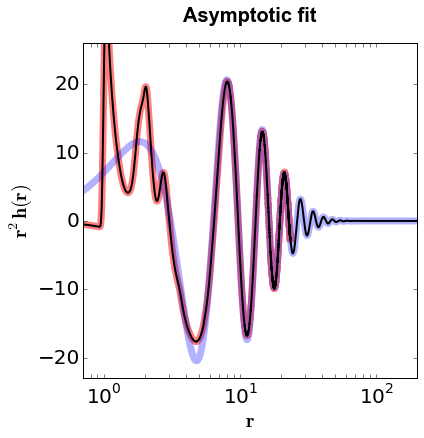

In [9]:
plot_fit(rdf_data, rdf_data_extended, x_min = 0.7, x_max = 200.0, y_min = -23.0, y_max = 26.0)

In [84]:
struct_fact_data = calculate_structure_factor(rdf_data_extended, 0.04, 0.05, 20.0, 0.05)

In [71]:
struct_fact_data

,k,S(k)
0,0.8,177.437157


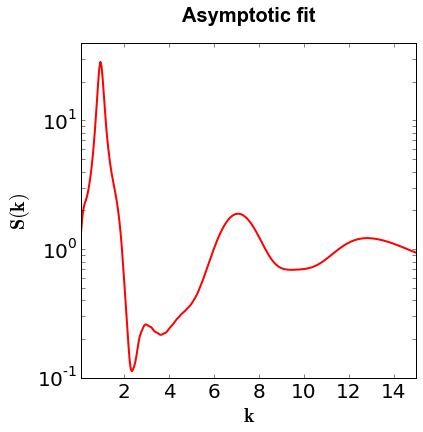

In [106]:
#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}
axescolor = '#f6f6f6'

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#actual data and labeling
plt.xlabel('$\mathbf{k}$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$\mathbf{S(k)}$', fontsize=20, fontdict = axis_label_font)

plt.plot(struct_fact_data ["k"], struct_fact_data ["S(k)"], c="r", linestyle = '-', linewidth = 2, alpha = 1.0)
#plt.scatter(struct_fact_data ["k"], struct_fact_data ["S(k)"], c="r", linestyle = '-', linewidth = 2, alpha = 1.0)

plt.ylim((0.1,40.0))
plt.xlim((0.1,15.0))
plt.yscale('log')

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title("Asymptotic fit", y=1.05, fontdict = title_font)

In [108]:
a = -9.08375178
z = 6.36225023
k0 = 0.95204627
q = 1.77534547
make_asymptotic_rdf = lambda x: asymptotic_rdf(x, a, z, k0, q)
rdf_data["h(r)"] = rdf_data["g(r)"].apply(lambda x: x - 1.0)
rdf_data["h(r)"] = rdf_data["h(r)"] * rdf_data["r"] * rdf_data["r"] 
rdf_data["h(r)_asmpt"] = rdf_data["r"].apply(make_asymptotic_rdf)

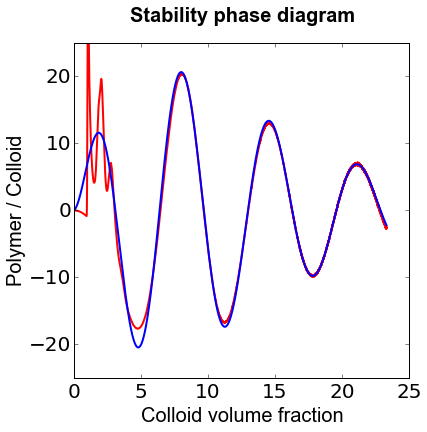

In [109]:
#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}
axescolor = '#f6f6f6'

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'


plt.xlabel('Colloid volume fraction', fontsize=20, fontdict = axis_label_font)
plt.ylabel('Polymer / Colloid', fontsize=20, fontdict = axis_label_font)
plt.plot(rdf_data["r"], rdf_data["h(r)"], c="r", linestyle = '-', linewidth = 2)
plt.plot(rdf_data["r"], rdf_data["h(r)_asmpt"], c="b", linestyle = '-', linewidth = 2)
#plt.scatter(rdf_data, boundary[2], c="b", linestyle = '-', linewidth = 2)
plt.ylim((-25,25))
plt.xlim((0,25))

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title("Stability phase diagram", y=1.05, fontdict = title_font)

In [14]:
rdf_data

,r,g(r),r2h(r),r2h(r)_asmpt
0,0.000,0.000000,-0.000000,NaN
1,0.005,0.000000,-0.000025,0.009430
2,0.010,0.000000,-0.000100,0.019267
3,0.015,0.000000,-0.000225,0.029510
4,0.020,0.000000,-0.000400,0.040157
5,0.025,0.000000,-0.000625,0.051206
6,0.030,0.000000,-0.000900,0.062656
7,0.035,0.000000,-0.001225,0.074504
8,0.040,0.000000,-0.001600,0.086750
9,0.045,0.000000,-0.002025,0.099392
